In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
"""
  recall: 使用numpy计算矩阵的特征值和特征向量
"""

import numpy as np

mat = np.array([
    [-1, 1, 0],
    [-4, 3, 0],
    [1, 0, 2]
])

eigenvalue, featurevector = np.linalg.eig(mat)

print("特征值：", eigenvalue)
print("特征向量：", featurevector) # note：特征向量需要按列看

特征值： [2. 1. 1.]
特征向量： [[ 0.          0.40824829  0.40824829]
 [ 0.          0.81649658  0.81649658]
 [ 1.         -0.40824829 -0.40824829]]


### Harris 角点检测

原理和实现参考：https://blog.csdn.net/my_kun/article/details/106918857

PCA复习：http://blog.codinglabs.org/articles/pca-tutorial.html

In [19]:
import cv2
import matplotlib.pyplot as plt

img_path1 = "/content/drive/MyDrive/CodeSpace/CUHK/CMSC_CV/FeatureExtract&Tracking/example_1.png"
img_path2 = "/content/drive/MyDrive/CodeSpace/CUHK/CMSC_CV/FeatureExtract&Tracking/example_2.png"
img_path3 = "/content/drive/MyDrive/CodeSpace/CUHK/CMSC_CV/FeatureExtract&Tracking/example_3.png"

# 读取图像
img1 = cv2.imread(img_path1, cv2.IMREAD_COLOR)
img2 = cv2.imread(img_path2, cv2.IMREAD_COLOR)
img3 = cv2.imread(img_path3, cv2.IMREAD_COLOR)

image shape --> h:939  w:1421  c:3
image shape --> h:474  w:474  c:3
image shape --> h:300  w:300  c:3


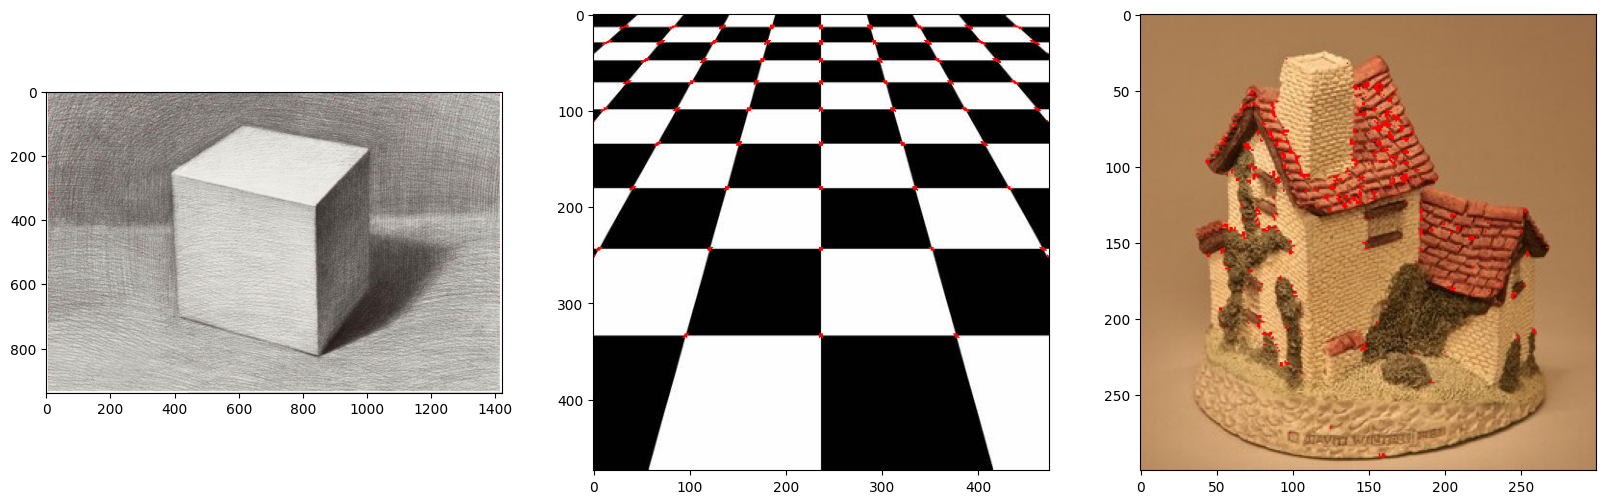

In [3]:
"""
  直接使用cv2 API
    @param blockSize Neighborhood size (see the details on #cornerEigenValsAndVecs ). 扫描时窗口大小
    @param ksize Aperture parameter for the Sobel operator. 使用Sobel算子，该参数定义了Sobel算子的中孔。简单来说，该函数定义了角点检测的敏感度，其值必须介于3~31之间的奇数。
    @param k Harris detector free parameter. See the formula below. 响应函数中的k值，一般取0.04~0.06
"""
import numpy as np
import cv2

def harris_detect(image):
  # original image
  h, w, c = image.shape
  print('image shape --> h:%d  w:%d  c:%d' % (h, w, c))

  # harris dst
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # gray = np.float32(gray)
  dst = cv2.cornerHarris(gray, blockSize=3, ksize=5, k=0.05)
  image_dst = image[:, :, :]
  image_dst[dst > 0.1 * dst.max()] = [0, 0, 255]
  return image_dst

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
harris_img1 = harris_detect(img1)
plt.imshow(cv2.cvtColor(harris_img1, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,2)
harris_img2 = harris_detect(img2)
plt.imshow(cv2.cvtColor(harris_img2, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,3)
harris_img3 = harris_detect(img3)
plt.imshow(cv2.cvtColor(harris_img3, cv2.COLOR_BGR2RGB))

image shape --> h:939  w:1421  c:3
0.0
-2816000356.0
image shape --> h:474  w:474  c:3
0.0
-10421796403.84
image shape --> h:300  w:300  c:3
0.0
-800618343.04


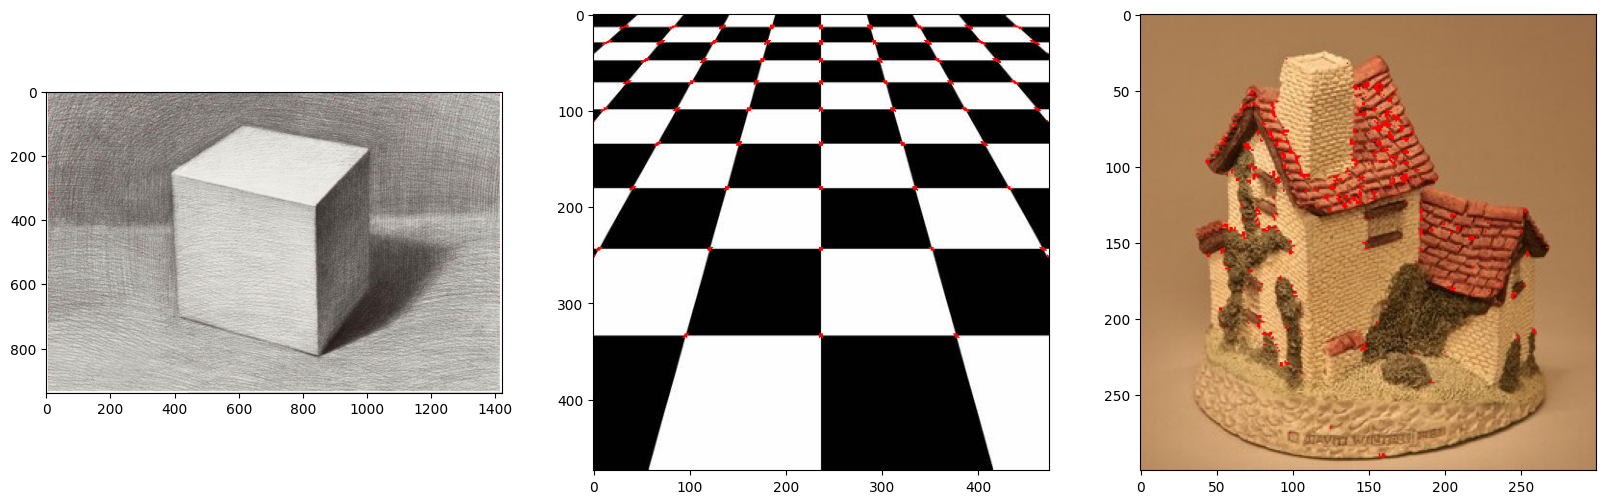

In [10]:
"""
  使用python实现一个Harris Detector
"""

def my_harris_det(img, block_size=3, ksize=3, k=0.04, threshold = 0.01, WITH_NMS = False):
    '''
    params:
        img:单通道灰度图片
        block_size:权重滑动窗口
        ksize：Sobel算子窗口大小
        k:响应函数参数k
        threshold:设定阈值
        WITH_NMS:非极大值抑制
    return：
        corner：角点位置图，与源图像一样大小，角点处像素值设置为255
    '''
    h, w = img.shape[:2]
    # 1.高斯权重
    gray = cv2.GaussianBlur(img, ksize=(ksize, ksize), sigmaX=2)

    # 2.计算梯度
    grad = np.zeros((h,w,2),dtype=np.float32)
    grad[:,:,0] = cv2.Sobel(gray,cv2.CV_16S,1,0,ksize=3) # x方向
    grad[:,:,1] = cv2.Sobel(gray,cv2.CV_16S,0,1,ksize=3) # y方向

    # 3.计算协方差矩阵
    m = np.zeros((h,w,3),dtype=np.float32)
    m[:,:,0] = grad[:,:,0]**2
    m[:,:,1] = grad[:,:,1]**2
    m[:,:,2] = grad[:,:,0]*grad[:,:,1]
    m = [np.array([
          [m[i,j,0],m[i,j,2]],[m[i,j,2],m[i,j,1]]
        ]) for i in range(h) for j in range(w)]

    # 4.计算局部特征结果矩阵M的特征值和响应函数R(i,j)=det(M)-k(trace(M))^2  0.04<=k<=0.06
    #   人为设计的角点响应函数，原理参考CSDN链接
    D,T = list(map(np.linalg.det, m)), list(map(np.trace, m))
    R = np.array([d-k*t**2 for d,t in zip(D,T)])

    # 5.将计算出响应函数的值R进行非极大值抑制，滤除一些不是角点的点，同时要满足大于设定的阈值
    #获取最大的R值
    R_max = np.max(R)
    print(R_max)
    print(np.min(R))
    R = R.reshape(h,w)
    corner = np.zeros_like(R, dtype=np.uint8)
    for i in range(h):
        for j in range(w):
            if WITH_NMS:
                #除了进行进行阈值检测 还对3x3邻域内非极大值进行抑制(导致角点很小，会看不清)
                if R[i,j] > R_max*threshold and R[i,j] == np.max(R[max(0,i-1):min(i+2,h-1),max(0,j-1):min(j+2,w-1)]):
                    corner[i,j] = 255
            else:
                #只进行阈值检测
                if R[i,j] > R_max*threshold :
                    corner[i,j] = 255
    return corner

def plot_harris_res(image):
  height, width, channel = image.shape
  print('image shape --> h:%d  w:%d  c:%d' % (height, width, channel))

  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  # gray = np.float32(gray)
  dst = my_harris_det(gray, WITH_NMS=True)

  image_dst = image[:, :, :]
  image_dst[dst > 0.01 * dst.max()] = [0, 0, 255]
  return image_dst

plt.figure(figsize=(20, 10))
plt.subplot(1,3,1)
harris_img1 = plot_harris_res(img1)
plt.imshow(cv2.cvtColor(harris_img1, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,2)
harris_img2 = plot_harris_res(img2)
plt.imshow(cv2.cvtColor(harris_img2, cv2.COLOR_BGR2RGB))
plt.subplot(1,3,3)
harris_img3 = plot_harris_res(img3)
plt.imshow(cv2.cvtColor(harris_img3, cv2.COLOR_BGR2RGB))


### (Normalized) Cross Correlation

实现&原理参考:https://zhuanlan.zhihu.com/p/136788696

In [18]:
import cv2
import matplotlib.pyplot as plt

img_path1 = "/content/drive/MyDrive/CodeSpace/CUHK/CMSC_CV/FeatureExtract&Tracking/left_1.png"
img_path2 = "/content/drive/MyDrive/CodeSpace/CUHK/CMSC_CV/FeatureExtract&Tracking/right_1.png"

# 读取图像
img_left = cv2.imread(img_path1, cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)

238561.9008597082


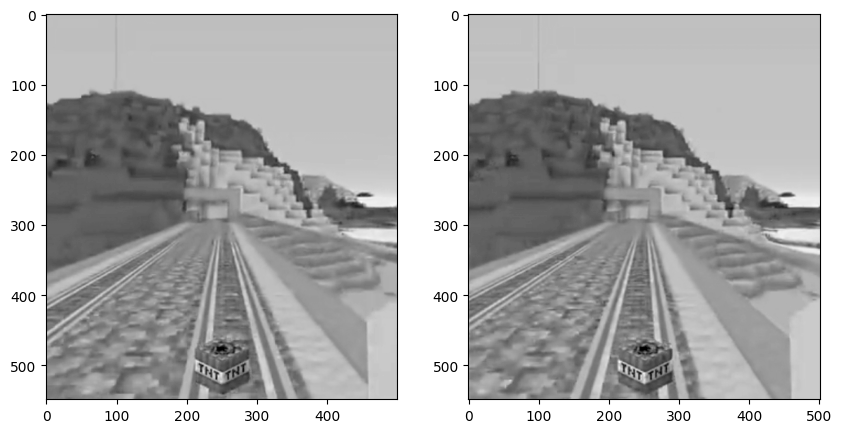

In [25]:
import numpy as np
import cv2

# 相关系数，这里使用的是有偏估计
def cal_cor(img_left, img_right):
  h,w = min(img_left.shape[0], img_right.shape[0]), min(img_left.shape[1], img_right.shape[1])
  img_left = cv2.resize(img_left, (h,w))
  img_right = cv2.resize(img_right, (h,w))
  diff_right = img_right - np.mean(img_right)
  diff_left = img_left - np.mean(img_left)
  std_right = np.std(img_right)
  std_left = np.std(img_left)
  cor = np.multiply(diff_left, diff_right).sum() / (std_right * std_left)
  return cor

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(img_left, cmap="gray")
plt.subplot(1,2,2)
plt.imshow(img_right, cmap='gray')
print(cal_cor(img_left, img_right))

-7016.860947288034


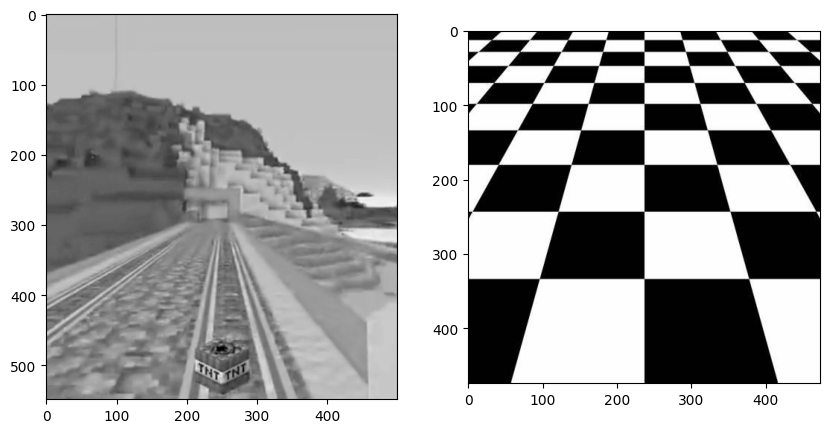

In [24]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(img_left, cmap="gray")
plt.subplot(1,2,2)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
plt.imshow(img2, cmap='gray')
print(cal_cor(img_left, img2_gray))